In [ ]:
from __future__ import annotations
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from typing import Any

from util_funcs import calculate_prevalence
from util_funcs import calculate_ci
from util_funcs import calculate_relrisk
from util_funcs import select_valid

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.3f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

### Load data & basic filtering / formatting

In [ ]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEERPLUS_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')
master.head()

In [ ]:

from util_funcs import do_basic_filtering
from util_funcs import do_basic_formatting
from util_funcs import remove_identical_primary_secondary_cases
from util_funcs import format_ln_status

print('\nFiltering')
maintable = do_basic_filtering(master.copy())
maintable = remove_identical_primary_secondary_cases(maintable)

print('\nFormatting')
maintable = do_basic_formatting(maintable)
maintable = format_ln_status(maintable, basis='pathological')
# maintable = format_ln_status(maintable, basis='clinical')

maintable.head()

### Features & table subsetting

In [ ]:
RESPONSE = 'brain_met'
FIELDS = [
    # 'GSTAGE_STD',
    'cancer_group',
    'hist_group',
    'diagnosis_agebin',
    'TSTAGE_STD',
    'NSTAGE_STD',
    'GRADE_STD',
    'local_ln',
    'distant_ln',
    RESPONSE
]
CATEGORICAL = {
    'cancer_group': [
        'Breast', 
        'Colorectal', 
        'Liver', 
        'Prostate', 
        'Pancreas', 
        'Stomach', 
        'Ovary', 
        'Thyroid', 
        'Kidney and Renal Pelvis', 
        'Lung and Bronchus', 
        'Skin'
    ],
    'hist_group': [
        'adenomas and adenocarcinomas',
        'epithelial neoplasms',
        'squamous cell neoplasms',
        'nevi and melanomas',
        'ductal and lobular neoplasms',
        'cystic, mucinous and serous neoplasms',
        'transitional cell papillomas and carcinomas',
        'acinar cell neoplasms',
        'nhl - mature b-cell lymphomas',
    ]
}

table = maintable[maintable[RESPONSE].notna()]
table = table[table['diagnosis_agebin']!='00 years']
table = table[table['diagnosis_agebin']!='Unknown']
for field, whitelist in CATEGORICAL.items():
    table = table[table[field].isin(whitelist)]

n_records_per_response = (table[RESPONSE]=='YES').sum()
ytable = table[table[RESPONSE]=='YES'].head(n_records_per_response)
ntable = table[table[RESPONSE]=='NO'].head(n_records_per_response)
shard = pd.concat([ytable, ntable], ignore_index=True).copy()
print(shard.shape)
print(shard[RESPONSE].value_counts(dropna=False))

In [ ]:
print(shard['cancer_group'].unique())
print(shard['hist_group'].unique())
shard[shard[RESPONSE]=='YES']['hist_group'].value_counts(dropna=False)

### Matrices

In [ ]:
print(shard['TSTAGE_STD'].value_counts(dropna=False))
print()
print(shard['NSTAGE_STD'].value_counts(dropna=False))
print()
print(shard['GRADE_STD'].value_counts(dropna=False))

In [ ]:
# encoding / standardisation
# should this imputation be constant? or a random values using frequencies as probabilities? 
TSTAGE_IMPUTE_CATEGORICAL = str(shard['TSTAGE_STD'].value_counts().index[0])
NSTAGE_IMPUTE_CATEGORICAL = str(shard['NSTAGE_STD'].value_counts().index[0])
GRADE_IMPUTE_CATEGORICAL = str(shard['GRADE_STD'].value_counts().index[0])

TSTAGE_IMPUTE_CONTINUOUS = int(shard['TSTAGE_STD'].value_counts().index[0][-1])
NSTAGE_IMPUTE_CONTINUOUS = int(shard['NSTAGE_STD'].value_counts().index[0][-1])
GRADE_IMPUTE_CONTINUOUS = int(shard['GRADE_STD'].value_counts().index[0][-1])

tstage_low = shard[shard['TSTAGE_STD']=='T1'].shape[0]
tstage_high = shard.dropna(subset=['TSTAGE_STD'])[shard['TSTAGE_STD']!='T1'].shape[0]
TSTAGE_IMPUTE_BINARY = 1 if tstage_low>tstage_high else 2

nstage_low = shard[shard['NSTAGE_STD']=='N0'].shape[0]
nstage_high = shard.dropna(subset=['NSTAGE_STD'])[shard['NSTAGE_STD']!='N0'].shape[0]
NSTAGE_IMPUTE_BINARY = 0 if nstage_low>nstage_high else 1

grade_low = shard[shard['GRADE_STD']=='G1'].shape[0]
grade_high = shard.dropna(subset=['GRADE_STD'])[shard['GRADE_STD']!='G1'].shape[0]
GRADE_IMPUTE_BINARY = 1 if grade_low>grade_high else 2

LOCAL_LN_IMPUTE = 0
DISTANT_LN_IMPUTE = 0

print(f"TSTAGE_IMPUTE_CATEGORICAL: {TSTAGE_IMPUTE_CATEGORICAL}")
print(f"NSTAGE_IMPUTE_CATEGORICAL: {NSTAGE_IMPUTE_CATEGORICAL}")
print(f"GRADE_IMPUTE_CATEGORICAL:  {GRADE_IMPUTE_CATEGORICAL}")

print(f"TSTAGE_IMPUTE_CONTINUOUS: {TSTAGE_IMPUTE_CONTINUOUS}")
print(f"NSTAGE_IMPUTE_CONTINUOUS: {NSTAGE_IMPUTE_CONTINUOUS}")
print(f"GRADE_IMPUTE_CONTINUOUS:  {GRADE_IMPUTE_CONTINUOUS}")

print(f"TSTAGE_IMPUTE_BINARY: {TSTAGE_IMPUTE_BINARY}")
print(f"NSTAGE_IMPUTE_BINARY: {NSTAGE_IMPUTE_BINARY}")
print(f"GRADE_IMPUTE_BINARY:  {GRADE_IMPUTE_BINARY}")

print(f"LOCAL_LN_IMPUTE: {LOCAL_LN_IMPUTE}")
print(f"DISTANT_LN_IMPUTE: {DISTANT_LN_IMPUTE}")

# continuous
def encode_agebin_continuous(text: str) -> int:
    return 100 if text == '90+ years' else int(text.split(' ')[0].split('-')[1])

def encode_tstage_continuous(text: Any) -> int:
    return int(text[-1]) if isinstance(text, str) else TSTAGE_IMPUTE_CONTINUOUS

def encode_nstage_continuous(text: Any) -> int:
    return int(text[-1]) if isinstance(text, str) else NSTAGE_IMPUTE_CONTINUOUS

def encode_grade_continuous(text: Any) -> int:
    return int(text[-1]) if isinstance(text, str) else GRADE_IMPUTE_CONTINUOUS

# binary
def encode_tstage_binary(text: Any) -> int:
    return min(int(text[-1]), 2) if isinstance(text, str) else TSTAGE_IMPUTE_BINARY

def encode_nstage_binary(text: Any) -> int:
    return min(int(text[-1]), 1) if isinstance(text, str) else NSTAGE_IMPUTE_BINARY

def encode_grade_binary(text: Any) -> int:
    return min(int(text[-1]), 2) if isinstance(text, str) else GRADE_IMPUTE_BINARY

# categorical
def encode_tstage_categorical(text: Any) -> str:
    return text if isinstance(text, str) else TSTAGE_IMPUTE_CATEGORICAL

def encode_nstage_categorical(text: Any) -> str:
    return text if isinstance(text, str) else NSTAGE_IMPUTE_CATEGORICAL

def encode_grade_categorical(text: Any) -> str:
    return text if isinstance(text, str) else GRADE_IMPUTE_CATEGORICAL

# conversions
def encode_bool_to_binary(value: bool) -> int:
    return 1 if value == True else 0 # TODO local/distant ln impute?

def encode_bool_to_categorical(text: Any) -> str:
    return 'positive' if text == True else 'negative'

In [ ]:
from abc import ABC, abstractmethod
from functools import cached_property

class DTableGenerator(ABC):
    table: pd.DataFrame
    fields: list[str]
    VERBOSE: bool=False

    @cached_property 
    @abstractmethod
    def predictors(self) -> dict[str, int]:
        ...
    
    @cached_property 
    @abstractmethod
    def funcmapper(self) -> dict:
        ...

    @abstractmethod
    def generate(self) -> pd.DataFrame:
        ...
    
    def summarise(self, df: pd.DataFrame) -> None:
        if not self.VERBOSE:
            return 

        columns = df.columns.to_list()
        for col in columns:
            if df[df[col].isna()].shape[0] > 0:
                print(f"{col} has NA values. ")
                raise RuntimeError
            print()
            print(df[col].value_counts(dropna=False))
        
        for i in range(0, len(columns), 3):
            if i == len(columns) - 1:
                print(f"{columns[i]:50s}")
            elif i == len(columns) - 2:
                print(f"{columns[i]:50s}{columns[i+1]:50s}")
            else:
                print(f"{columns[i]:50s}{columns[i+1]:50s}{columns[i+2]:50s}")
        print()
        print(df.iloc[:10, :10])
        print()
        print(df.iloc[:10, -10:])

class ContinuousTableGenerator(DTableGenerator):
    catfields: list[str]

    def __init__(self, table: pd.DataFrame, fields: list[str], catfields: list[str]) -> None:
        self.table = table.copy()
        self.fields = fields
        self.catfields = catfields
        self.table[RESPONSE] = self.table[RESPONSE].apply(lambda x: True if x=='YES' else False)
        print(self.table[RESPONSE].value_counts(dropna=False))

    @cached_property 
    def predictors(self) -> dict[str, int]:
        i = 0 
        predictors = dict()
        for field in self.fields:
            # one-hot encoding for inherent categorical variables
            if self.catfields is not None and field in self.catfields:
                features = sorted(list(self.table[field].unique()))
                for feat in features:
                    predictors[feat] = i
                    i += 1
            else:
                predictors[field] = i
                i += 1
        return predictors
    
    @cached_property
    def funcmapper(self) -> dict:
        return {
            'diagnosis_agebin': encode_agebin_continuous,
            'TSTAGE_STD': encode_tstage_continuous,
            'NSTAGE_STD': encode_nstage_continuous,
            'GRADE_STD': encode_grade_continuous,
            'local_ln': encode_bool_to_binary,
            'distant_ln': encode_bool_to_binary,
            RESPONSE: encode_bool_to_binary,
        }

    def generate(self) -> pd.DataFrame:
        # populate matrix
        data = []
        cols = list(self.predictors.keys())
        for i, row in self.table.iterrows():
            line = [0] * len(cols)
            if int(i) % 1000 == 0:
                print(f"processed {i} records...", end='\r')
            
            for field in self.fields:
                # column index
                if field in self.catfields:
                    idx = self.predictors[row[field]]
                else:
                    idx = self.predictors[field]
                
                # encoded value
                if field in self.funcmapper:
                    value = self.funcmapper[field](row[field])
                elif field in self.catfields:
                    value = 1
                else:
                    raise RuntimeError

                line[idx] = value
            
            data.append(line)

        df = pd.DataFrame(data=data, columns=cols)
        self.summarise(df)
        return df

class CategoricalTableGenerator(DTableGenerator):

    def __init__(self, table: pd.DataFrame, fields: list[str]) -> None:
        self.table = table.copy()
        self.fields = fields
        self.table[RESPONSE] = self.table[RESPONSE].apply(lambda x: True if x=='YES' else False)
        print(self.table[RESPONSE].value_counts(dropna=False))

    @cached_property 
    def predictors(self) -> dict[str, int]:
        return {field: i for i, field in enumerate(self.fields)}
    
    @cached_property 
    def funcmapper(self) -> dict:
        return {
            'TSTAGE_STD': encode_tstage_categorical,
            'NSTAGE_STD': encode_nstage_categorical,
            'GRADE_STD': encode_grade_categorical,
            'local_ln': encode_bool_to_categorical,
            'distant_ln': encode_bool_to_categorical,
            RESPONSE: encode_bool_to_categorical,
        }

    def generate(self) -> pd.DataFrame:
        data = []
        cols = list(self.predictors.keys())
        for i, row in self.table.iterrows():
            line = [0] * len(cols)
            if int(i) % 1000 == 0:
                print(f"processed {i} records...", end='\r')
            
            for field in self.fields:
                # column index
                idx = self.predictors[field]
                
                # encoded value
                if field in self.funcmapper:
                    value = self.funcmapper[field](row[field])
                else:
                    value = row[field]

                line[idx] = value
            
            data.append(line)

        df = pd.DataFrame(data=data, columns=cols)
        self.summarise(df)
        return df

# dtable = ContinuousTableGenerator(shard, FIELDS, list(CATEGORICAL.keys())).generate()
# dtable = CategoricalTableGenerator(shard, FIELDS).generate()

In [34]:
dtable_cnt = ContinuousTableGenerator(shard, FIELDS, list(CATEGORICAL.keys())).generate()
dtable_cat = CategoricalTableGenerator(shard, FIELDS).generate()

brain_met
True     53326
False    53326
Name: count, dtype: int64
brain_met 106000 records...
True     53326
False    53326
Name: count, dtype: int64


### Decision Tree

brain_met
True     53326
False    53326
Name: count, dtype: int64
[1, 1, 1, 1, 0, 0, 0, 1, 0, 1]
[0 1 1 1 0 1 1 1 0 1]
Precision: 0.8686117467581999
Recall:    0.8554793877359377
Accuracy:  0.863250668041817
F1:        0.8619955528220655
MCC:       0.7265770861939097


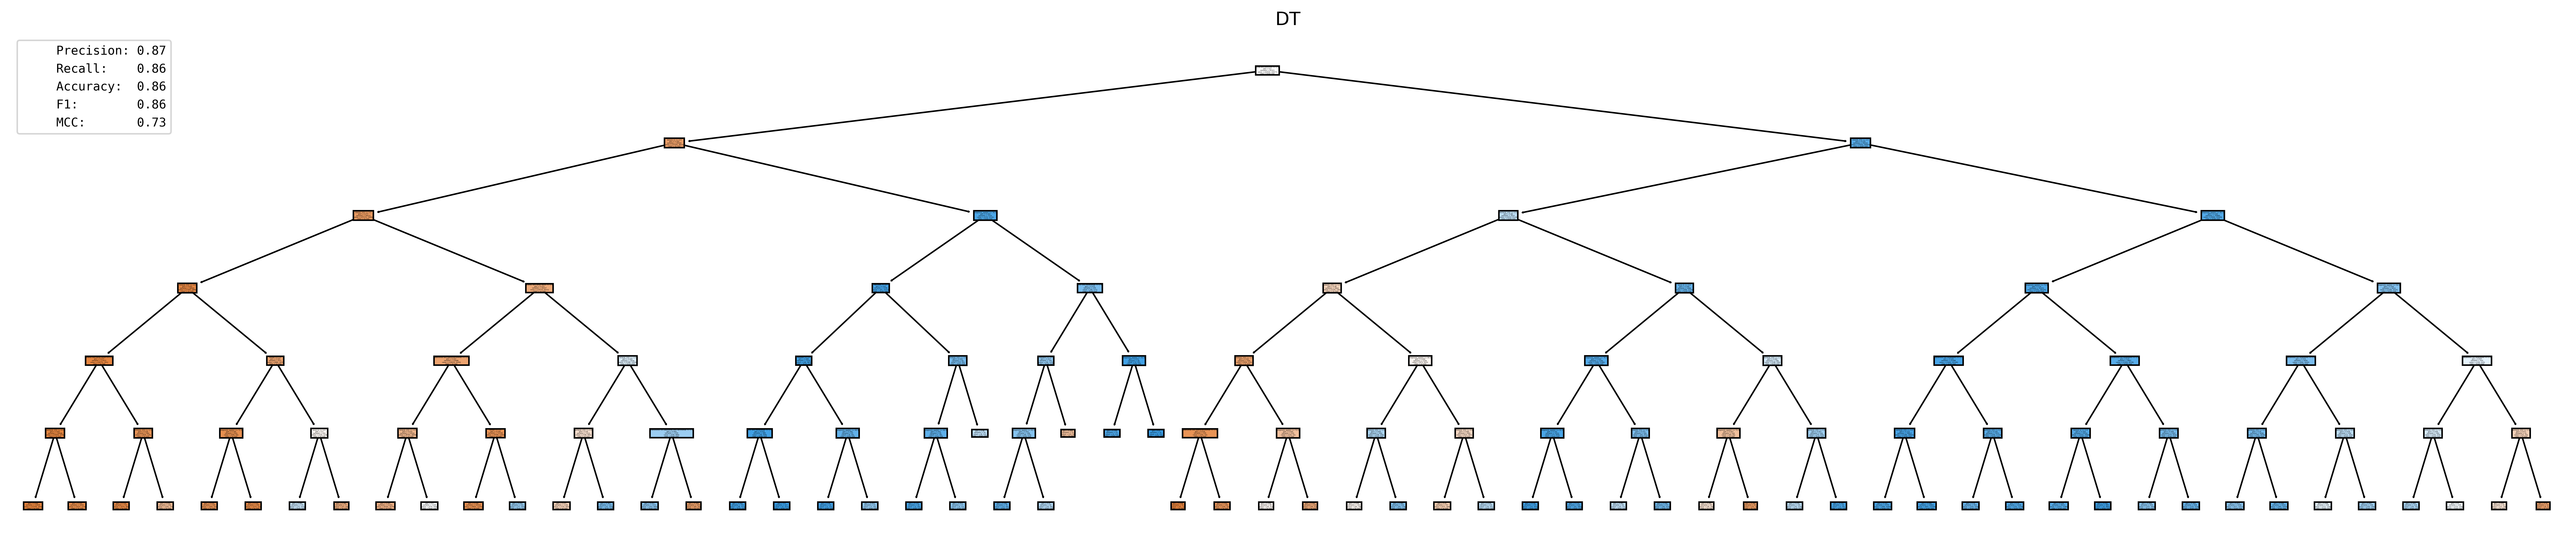

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef
import numpy as np 

dtable = dtable_cnt.copy()
preds = [x for x in dtable.columns if x!=RESPONSE]
X_train, X_test, y_train, y_test = train_test_split(dtable[preds], dtable[RESPONSE].to_list(), test_size=0.20)

clf = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(y_test[:10])
print(y_pred[:10])

print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall:    {recall_score(y_test, y_pred)}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred)}")
print(f"F1:        {f1_score(y_test, y_pred)}")
print(f"MCC:       {matthews_corrcoef(y_test, y_pred)}")

fig = plt.figure(figsize=(30, 6), dpi=500)
tree.plot_tree(clf, feature_names=preds, class_names=['no met', 'brain met'], filled=True)
plt.plot([], [], ' ', label=f"Precision: {precision_score(y_test, y_pred):.2f}")
plt.plot([], [], ' ', label=f"Recall:    {recall_score(y_test, y_pred):.2f}")
plt.plot([], [], ' ', label=f"Accuracy:  {accuracy_score(y_test, y_pred):.2f}")
plt.plot([], [], ' ', label=f"F1:        {f1_score(y_test, y_pred):.2f}")
plt.plot([], [], ' ', label=f"MCC:       {matthews_corrcoef(y_test, y_pred):.2f}")
plt.legend(loc='upper left', prop={'family': 'monospace', 'size': 8})
plt.title(f"DT")
plt.savefig('/home/grace/work/SEER/outputs/model_DT.png')
plt.show()

# best: 
# Precision: 0.8686117467581999
# Recall:    0.8554793877359377
# Accuracy:  0.863250668041817
# F1:        0.8619955528220655
# MCC:       0.7265770861939097

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import CategoricalNB
from collections import defaultdict

dtable = dtable_cat.copy()
preds = [x for x in dtable.columns if x!=RESPONSE]

# map string values to ints (seems CategoricalNB needs this)
label_encoder = defaultdict(dict)
for col in dtable.columns:
    label_encoder[col] = {v: i for i, v in enumerate(sorted(list(dtable[col].unique())))}
    dtable[col] = dtable[col].map(label_encoder[col])

# print()
# print(dtable.head())
# print()
# print(dtable.tail())
X_train, X_test, y_train, y_test = train_test_split(dtable[preds], dtable[RESPONSE].to_list(), test_size=0.20)

clf = CategoricalNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(y_test[:10])
print(y_pred[:10])
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall:    {recall_score(y_test, y_pred)}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred)}")
print(f"F1:        {f1_score(y_test, y_pred)}")
print(f"MCC:       {matthews_corrcoef(y_test, y_pred)}")

[0, 1, 0, 0, 1, 0, 1, 0, 1, 0]
[1 1 0 0 1 0 1 0 1 1]
Precision: 0.8717419101013082
Recall:    0.8305688314122388
Accuracy:  0.8541090431765974
F1:        0.8506574527305883
MCC:       0.7090171588647127


### Neural Network

In [48]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np

num_cores = os.cpu_count()
tf.config.threading.set_intra_op_parallelism_threads(num_cores)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)

dtable = dtable_cnt.copy()
preds = [x for x in dtable.columns if x!=RESPONSE]
X_train, X_test, y_train, y_test = train_test_split(dtable[preds].astype(float), dtable[RESPONSE].to_list(), test_size=0.20)
print(len(y_train), sum(y_train))
print(len(y_test), sum(y_test))

# 1. Define the network
model = Sequential()
model.add(Dense(3, activation='relu', name="layer1", input_shape=(len(preds),))) # Input layer
model.add(Dropout(0.5)) # Dropout layer with a 50% dropout rate)
model.add(Dense(3, activation='relu', name="layer2"))
model.add(Dense(1, activation='sigmoid')) # Output layer
model.summary()

# 2. Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

# 3. Train the model
model.fit(X_train, np.array(y_train), epochs=20, batch_size=32, validation_data=(X_test, np.array(y_test)))

# 4. Evaluate the model
y_pred = model.predict(X_test)
y_pred = [int(x+0.5) for x in y_pred]
print(y_test[:10])
print(y_pred[:10])
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall:    {recall_score(y_test, y_pred)}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred)}")
print(f"F1:        {f1_score(y_test, y_pred)}")
print(f"MCC:       {matthews_corrcoef(y_test, y_pred)}")

85321 42571
21331 10755


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 3)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94 (376.00 B)

 Trainable params: 94 (376.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6283 - loss: 0.4155 - val_accuracy: 0.8569 - val_loss: 0.1897
Epoch 2/20
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7638 - loss: 0.2617 - val_accuracy: 0.8584 - val_loss: 0.1558
Epoch 3/20
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7684 - loss: 0.2396 - val_accuracy: 0.8618 - val_loss: 0.1437
Epoch 4/20
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7688 - loss: 0.2347 - val_accuracy: 0.8621 - val_loss: 0.1413
Epoch 5/20
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7720 - loss: 0.2302 - val_accuracy: 0.8644 - val_loss: 0.1384
Epoch 6/20
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7733 - loss: 0.2278 - val_accuracy: 0.8640 - val_loss: 0.1374
Epoch 7/20
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7709 - loss: 0.2303 - val_accuracy: 0.8646 - val_loss: 0.1368
Epoch 8/20
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7713 - loss: 0.2301 - 